In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import datetime
import matplotlib
import seaborn as sns
import datetime
import shap

In [3]:
pd.set_option('display.max_rows', 10)

In [4]:
cwd = os.getcwd()
print(cwd)
cwd_parent = os.path.abspath(os.path.join(cwd, '../../'))
print(cwd_parent)

sys.path.append(cwd_parent)

/opt/data/chemprop_run/git/notebooks/AltModels
/opt/data/chemprop_run/git


In [5]:
import deepadr
from deepadr.dataset import *
from deepadr.utilities import *
from deepadr.run_workflow import *
from deepadr.chemfeatures import *
from deepadr.hyphelperflat import *

In [6]:
rawdata_dir = '../data/raw/'
processed_dir = '../data/processed/'
up_dir = '..'

In [7]:
report_available_cuda_devices()

number of GPUs available: 1
cuda:0, name:NVIDIA GeForce GTX 1080 Ti
total memory available: 10.91656494140625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB



In [8]:
n_gpu = torch.cuda.device_count()
n_gpu

1

In [9]:
device_cpu = get_device(to_gpu=False)
# device_gpu = get_device(True, index=0)

# fdtype = torch.float32

In [10]:
print("torch:", torch.__version__)
print("CUDA:", torch.version.cuda)
print(sys.version)

torch: 1.9.1
CUDA: 11.1
3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:41:03) 
[GCC 9.4.0]


### Preparing dataset 

In [11]:
score = 'total_thresh'
score_val = 4

In [12]:
DSdataset_name = f'DrugComb_{score}_{score_val}'

# v_1: GNN
# v_2: Alt Models (Baseline)
data_fname = 'data_v2'

In [13]:
targetdata_dir = create_directory(os.path.join(processed_dir, DSdataset_name, data_fname))
targetdata_dir_raw = create_directory(os.path.join(targetdata_dir, "raw"))
targetdata_dir_processed = create_directory(os.path.join(targetdata_dir, "processed"))
targetdata_dir_exp = create_directory(os.path.join(targetdata_dir, "experiments"))
print(targetdata_dir)

path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
path_current_dir /opt/data/chemprop_run/git/deepadr
/opt/data/chemprop_run/git/data/processed/DrugComb_total_thresh_4/data_v2


In [14]:
x_np_norm = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'x_np_norm.pkl'))
y = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'y.pkl'))

In [15]:
fold_partitions = get_stratified_partitions(y,
                                            num_folds=5,
                                            valid_set_portion=0.1,
                                            random_state=42)

fold_num: 0
train data
class: 0 norm count: 0.5764128559102675
class: 1 norm count: 0.4235871440897325
validation data
class: 0 norm count: 0.5764192139737991
class: 1 norm count: 0.42358078602620086
test data
class: 0 norm count: 0.5764751552795031
class: 1 norm count: 0.4235248447204969

-------------------------
fold_num: 1
train data
class: 0 norm count: 0.5764128559102675
class: 1 norm count: 0.4235871440897325
validation data
class: 0 norm count: 0.5764192139737991
class: 1 norm count: 0.42358078602620086
test data
class: 0 norm count: 0.5764751552795031
class: 1 norm count: 0.4235248447204969

-------------------------
fold_num: 2
train data
class: 0 norm count: 0.5764356969533567
class: 1 norm count: 0.4235643030466433
validation data
class: 0 norm count: 0.5764192139737991
class: 1 norm count: 0.42358078602620086
test data
class: 0 norm count: 0.5763929334109882
class: 1 norm count: 0.4236070665890118

-------------------------
fold_num: 3
train data
class: 0 norm count: 0.576

### Preprocessing

In [16]:
deepsynergy_input_size = x_np_norm.shape[1]
deepsynergy_input_size

926

In [17]:
ids = list(range(len(y)))

### Get Drug and Cell Line names

In [18]:
df_all = pd.read_pickle(os.path.join(targetdata_dir_processed, 'total_thresh_4_v2_predictions.pkl'))
df_all

,true_class,pred_class,prob_score_class0,prob_score_class1,Drug1_ID,Drug2_ID,Cell_Line_ID,Cosmic_ID,Drug1,Drug2,Y
0,0,0,0.999812,0.000188,dacarbazine,717906-29-1,A-673,684052,CN(C)N=NC1=C(NC=N1)C(=O)N,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
1,0,0,0.996824,0.003176,Nesbuvir,717906-29-1,A-673,684052,CNC(=O)C1=C(OC2=CC(=C(C=C21)C3CC3)N(CCO)S(=O)(...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
2,0,0,0.838370,0.161630,Avagacestat,717906-29-1,A-673,684052,C1=CC(=CC=C1S(=O)(=O)N(CC2=C(C=C(C=C2)C3=NOC=N...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
3,1,0,0.999247,0.000753,AS601245,717906-29-1,A-673,684052,C1=CC=C2C(=C1)N=C(S2)C(C#N)C3=NC(=NC=C3)NCCC4=...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,1
4,0,1,0.000050,0.999950,CHEMBL166161,717906-29-1,A-673,684052,COC1(CCN(CC1)CCC2=CNC3=C2C=C(C=C3)F)CS(=O)C4=C...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
...,...,...,...,...,...,...,...,...,...,...,...
25752,0,0,0.991160,0.008840,AZD7762,AZD2014,VM-CUB-1,909780,C1CC(CNC1)NC(=O)C2=C(C=C(S2)C3=CC(=CC=C3)F)NC(...,CC1COCCN1C2=NC(=NC3=C2C=CC(=N3)C4=CC(=CC=C4)C(...,0
25753,0,0,0.993270,0.006730,AZD-4877,Onalespib,VM-CUB-1,909780,CC1=CC=C(C=C1)C(=O)N(CCCN)C(C2=NC3=C(C(=NS3)C)...,CC(C)C1=C(C=C(C(=C1)C(=O)N2CC3=C(C2)C=C(C=C3)C...,0
25754,0,1,0.390352,0.609648,Sapitinib,Vorinostat,VM-CUB-1,909780,CNC(=O)CN1CCC(CC1)OC2=C(C=C3C(=C2)C(=NC=N3)NC4...,C1=CC=C(C=C1)NC(=O)CCCCCCC(=O)NO,0
25755,1,0,0.991512,0.008488,957054-30-7,Sapitinib,VM-CUB-1,909780,CS(=O)(=O)N1CCN(CC1)CC2=CC3=C(S2)C(=NC(=N3)C4=...,CNC(=O)CN1CCC(CC1)OC2=C(C=C3C(=C2)C(=NC=N3)NC4...,1


In [19]:
df_pred_TP = df_all[((df_all.true_class == 0) & (df_all.pred_class == 0)) |
                     ((df_all.true_class == 1) & (df_all.pred_class == 1))]
df_pred_TP

,true_class,pred_class,prob_score_class0,prob_score_class1,Drug1_ID,Drug2_ID,Cell_Line_ID,Cosmic_ID,Drug1,Drug2,Y
0,0,0,0.999812,0.000188,dacarbazine,717906-29-1,A-673,684052,CN(C)N=NC1=C(NC=N1)C(=O)N,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
1,0,0,0.996824,0.003176,Nesbuvir,717906-29-1,A-673,684052,CNC(=O)C1=C(OC2=CC(=C(C=C21)C3CC3)N(CCO)S(=O)(...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
2,0,0,0.838370,0.161630,Avagacestat,717906-29-1,A-673,684052,C1=CC(=CC=C1S(=O)(=O)N(CC2=C(C=C(C=C2)C3=NOC=N...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
6,1,1,0.010439,0.989561,AT7519,PF-3758309,TC-71,1240221,C1CNCCC1NC(=O)C2=C(C=NN2)NC(=O)C3=C(C=CC=C3Cl)Cl,CC1=NC2=C(C(=N1)NC3=NNC4=C3CN(C4(C)C)C(=O)NC(C...,1
7,1,1,0.000052,0.999948,ZINC34894448,PF-3758309,TC-71,1240221,CCC1=C2N=C(C=C(N2N=C1)NCC3=C[N+](=CC=C3)[O-])N...,CC1=NC2=C(C(=N1)NC3=NNC4=C3CN(C4(C)C)C(=O)NC(C...,1
...,...,...,...,...,...,...,...,...,...,...,...
25750,0,0,0.976813,0.023187,AZD7762,AZD6738,VM-CUB-1,909780,C1CC(CNC1)NC(=O)C2=C(C=C(S2)C3=CC(=CC=C3)F)NC(...,CC1COCCN1C2=NC(=NC(=C2)C3(CC3)S(=N)(=O)C)C4=C5...,0
25751,0,0,0.989993,0.010007,AZD7762,AZD4547,VM-CUB-1,909780,C1CC(CNC1)NC(=O)C2=C(C=C(S2)C3=CC(=CC=C3)F)NC(...,CC1CN(CC(N1)C)C2=CC=C(C=C2)C(=O)NC3=NNC(=C3)CC...,0
25752,0,0,0.991160,0.008840,AZD7762,AZD2014,VM-CUB-1,909780,C1CC(CNC1)NC(=O)C2=C(C=C(S2)C3=CC(=CC=C3)F)NC(...,CC1COCCN1C2=NC(=NC3=C2C=CC(=N3)C4=CC(=CC=C4)C(...,0
25753,0,0,0.993270,0.006730,AZD-4877,Onalespib,VM-CUB-1,909780,CC1=CC=C(C=C1)C(=O)N(CCCN)C(C2=NC3=C(C(=NS3)C)...,CC(C)C1=C(C=C(C(=C1)C(=O)N2CC3=C(C2)C=C(C=C3)C...,0


In [20]:
df_pred_TP_RI = df_pred_TP.reset_index()
df_pred_TP_RI

,index,true_class,pred_class,prob_score_class0,prob_score_class1,Drug1_ID,Drug2_ID,Cell_Line_ID,Cosmic_ID,Drug1,Drug2,Y
0,0,0,0,0.999812,0.000188,dacarbazine,717906-29-1,A-673,684052,CN(C)N=NC1=C(NC=N1)C(=O)N,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
1,1,0,0,0.996824,0.003176,Nesbuvir,717906-29-1,A-673,684052,CNC(=O)C1=C(OC2=CC(=C(C=C21)C3CC3)N(CCO)S(=O)(...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
2,2,0,0,0.838370,0.161630,Avagacestat,717906-29-1,A-673,684052,C1=CC(=CC=C1S(=O)(=O)N(CC2=C(C=C(C=C2)C3=NOC=N...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
3,6,1,1,0.010439,0.989561,AT7519,PF-3758309,TC-71,1240221,C1CNCCC1NC(=O)C2=C(C=NN2)NC(=O)C3=C(C=CC=C3Cl)Cl,CC1=NC2=C(C(=N1)NC3=NNC4=C3CN(C4(C)C)C(=O)NC(C...,1
4,7,1,1,0.000052,0.999948,ZINC34894448,PF-3758309,TC-71,1240221,CCC1=C2N=C(C=C(N2N=C1)NCC3=C[N+](=CC=C3)[O-])N...,CC1=NC2=C(C(=N1)NC3=NNC4=C3CN(C4(C)C)C(=O)NC(C...,1
...,...,...,...,...,...,...,...,...,...,...,...,...
21013,25750,0,0,0.976813,0.023187,AZD7762,AZD6738,VM-CUB-1,909780,C1CC(CNC1)NC(=O)C2=C(C=C(S2)C3=CC(=CC=C3)F)NC(...,CC1COCCN1C2=NC(=NC(=C2)C3(CC3)S(=N)(=O)C)C4=C5...,0
21014,25751,0,0,0.989993,0.010007,AZD7762,AZD4547,VM-CUB-1,909780,C1CC(CNC1)NC(=O)C2=C(C=C(S2)C3=CC(=CC=C3)F)NC(...,CC1CN(CC(N1)C)C2=CC=C(C=C2)C(=O)NC3=NNC(=C3)CC...,0
21015,25752,0,0,0.991160,0.008840,AZD7762,AZD2014,VM-CUB-1,909780,C1CC(CNC1)NC(=O)C2=C(C=C(S2)C3=CC(=CC=C3)F)NC(...,CC1COCCN1C2=NC(=NC3=C2C=CC(=N3)C4=CC(=CC=C4)C(...,0
21016,25753,0,0,0.993270,0.006730,AZD-4877,Onalespib,VM-CUB-1,909780,CC1=CC=C(C=C1)C(=O)N(CCCN)C(C2=NC3=C(C(=NS3)C)...,CC(C)C1=C(C=C(C(=C1)C(=O)N2CC3=C(C2)C=C(C=C3)C...,0


In [21]:
fold_partitions_TP_test = {}

for fold, part in fold_partitions.items():
    fold_partitions_TP_test[fold] = df_pred_TP_RI['index'][df_pred_TP_RI['index'].isin(fold_partitions[fold]['test'])].index.values

In [22]:
df_pred_TP_RI = df_pred_TP_RI.drop(columns=["index"])
df_pred_TP_RI

,true_class,pred_class,prob_score_class0,prob_score_class1,Drug1_ID,Drug2_ID,Cell_Line_ID,Cosmic_ID,Drug1,Drug2,Y
0,0,0,0.999812,0.000188,dacarbazine,717906-29-1,A-673,684052,CN(C)N=NC1=C(NC=N1)C(=O)N,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
1,0,0,0.996824,0.003176,Nesbuvir,717906-29-1,A-673,684052,CNC(=O)C1=C(OC2=CC(=C(C=C21)C3CC3)N(CCO)S(=O)(...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
2,0,0,0.838370,0.161630,Avagacestat,717906-29-1,A-673,684052,C1=CC(=CC=C1S(=O)(=O)N(CC2=C(C=C(C=C2)C3=NOC=N...,CN(C1=CC=CC=C1CNC2=NC(=NC=C2C(F)(F)F)NC3=CC4=C...,0
3,1,1,0.010439,0.989561,AT7519,PF-3758309,TC-71,1240221,C1CNCCC1NC(=O)C2=C(C=NN2)NC(=O)C3=C(C=CC=C3Cl)Cl,CC1=NC2=C(C(=N1)NC3=NNC4=C3CN(C4(C)C)C(=O)NC(C...,1
4,1,1,0.000052,0.999948,ZINC34894448,PF-3758309,TC-71,1240221,CCC1=C2N=C(C=C(N2N=C1)NCC3=C[N+](=CC=C3)[O-])N...,CC1=NC2=C(C(=N1)NC3=NNC4=C3CN(C4(C)C)C(=O)NC(C...,1
...,...,...,...,...,...,...,...,...,...,...,...
21013,0,0,0.976813,0.023187,AZD7762,AZD6738,VM-CUB-1,909780,C1CC(CNC1)NC(=O)C2=C(C=C(S2)C3=CC(=CC=C3)F)NC(...,CC1COCCN1C2=NC(=NC(=C2)C3(CC3)S(=N)(=O)C)C4=C5...,0
21014,0,0,0.989993,0.010007,AZD7762,AZD4547,VM-CUB-1,909780,C1CC(CNC1)NC(=O)C2=C(C=C(S2)C3=CC(=CC=C3)F)NC(...,CC1CN(CC(N1)C)C2=CC=C(C=C2)C(=O)NC3=NNC(=C3)CC...,0
21015,0,0,0.991160,0.008840,AZD7762,AZD2014,VM-CUB-1,909780,C1CC(CNC1)NC(=O)C2=C(C=C(S2)C3=CC(=CC=C3)F)NC(...,CC1COCCN1C2=NC(=NC3=C2C=CC(=N3)C4=CC(=CC=C4)C(...,0
21016,0,0,0.993270,0.006730,AZD-4877,Onalespib,VM-CUB-1,909780,CC1=CC=C(C=C1)C(=O)N(CCCN)C(C2=NC3=C(C(=NS3)C)...,CC(C)C1=C(C=C(C(=C1)C(=O)N2CC3=C(C2)C=C(C=C3)C...,0


In [23]:
df_pred_TP_zeros = df_pred_TP_RI[df_pred_TP_RI.true_class == 0]
df_pred_TP_ones = df_pred_TP_RI[df_pred_TP_RI.true_class == 1]

In [24]:
sel_CellLine = "A101D"
sel_Drug1_ID = "Navitoclax"
sel_Drug2_ID = "Silmitasertib" # Silmitasertib  Decitabine Dovitinib Fludarabine Cediranib 

In [25]:
df_pred_TP_CellLine_zeros = df_pred_TP_zeros[df_pred_TP_zeros.Cell_Line_ID == sel_CellLine]
print(len(df_pred_TP_CellLine_zeros))

df_pred_TP_CellLine_ones = df_pred_TP_ones[df_pred_TP_ones.Cell_Line_ID == sel_CellLine]
print(len(df_pred_TP_CellLine_ones))

df_pred_TP_Instance = df_pred_TP_RI[(df_pred_TP_RI.Cell_Line_ID == sel_CellLine) &
                                 (df_pred_TP_RI.Drug1_ID == sel_Drug1_ID) & 
                                 (df_pred_TP_RI.Drug2_ID == sel_Drug2_ID)]

858
115


In [26]:
df_pred_TP_Instance

,true_class,pred_class,prob_score_class0,prob_score_class1,Drug1_ID,Drug2_ID,Cell_Line_ID,Cosmic_ID,Drug1,Drug2,Y
12649,1,1,0.302058,0.697942,Navitoclax,Silmitasertib,A101D,910921,CC1(CCC(=C(C1)CN2CCN(CC2)C3=CC=C(C=C3)C(=O)NS(...,C1=CC(=CC(=C1)Cl)NC2=C3C=CN=CC3=C4C=CC(=CC4=N2...,1


### Load Attributions

In [27]:
concat_folds_min = pd.read_pickle(os.path.join(targetdata_dir_processed, 'total_thresh_4_v2_attributions.pkl'))
concat_deltas_min = pd.read_pickle(os.path.join(targetdata_dir_processed, 'total_thresh_4_v2_deltas.pkl'))


In [28]:
delta_thresh = 1.0

In [29]:
sel_deltas = concat_deltas_min[(concat_deltas_min>=-delta_thresh) & (concat_deltas_min<=delta_thresh)].index.values
print(len(sel_deltas), len(concat_deltas_min))

12487 21018


In [30]:
sel_idx_zeros = np.intersect1d(df_pred_TP_zeros.index, sel_deltas)
sel_idx_ones = np.intersect1d(df_pred_TP_ones.index, sel_deltas)

sel_idx_CellLine_zeros = np.intersect1d(df_pred_TP_CellLine_zeros.index, sel_deltas)
sel_idx_CellLine_ones = np.intersect1d(df_pred_TP_CellLine_ones.index, sel_deltas)

print(sel_idx_zeros.shape, len(df_pred_TP_zeros.index))
print(sel_idx_ones.shape, len(df_pred_TP_ones.index))

print(sel_idx_CellLine_zeros.shape, len(df_pred_TP_CellLine_zeros.index))
print(sel_idx_CellLine_ones.shape, len(df_pred_TP_CellLine_ones.index))

(7739,) 12241
(4748,) 8777
(524,) 858
(68,) 115


In [31]:
test_features_TP = np.take(x_np_norm, df_pred_TP.index.values, axis=0)
test_features_TP.shape

(21018, 926)

In [32]:
test_features_TP_zeros_delta_thresh = np.take(test_features_TP, sel_idx_zeros, axis=0)
print(test_features_TP_zeros_delta_thresh.shape)

test_features_TP_ones_delta_thresh = np.take(test_features_TP, sel_idx_ones, axis=0)
print(test_features_TP_ones_delta_thresh.shape)

test_features_TP_CellLine_zeros_delta_thresh = np.take(test_features_TP, sel_idx_CellLine_zeros, axis=0)
print(test_features_TP_CellLine_zeros_delta_thresh.shape)

test_features_TP_CellLine_ones_delta_thresh = np.take(test_features_TP, sel_idx_CellLine_ones, axis=0)
print(test_features_TP_CellLine_ones_delta_thresh.shape)

test_features_TP_Instance = np.take(test_features_TP, df_pred_TP_Instance.index, axis=0)
print(test_features_TP_Instance.shape)

(7739, 926)
(4748, 926)
(524, 926)
(68, 926)
(1, 926)


In [33]:
concat_folds_min_zeros_delta_thresh = concat_folds_min.loc[sel_idx_zeros].values
print(concat_folds_min_zeros_delta_thresh.shape)

concat_folds_min_ones_delta_thresh = concat_folds_min.loc[sel_idx_ones].values
print(concat_folds_min_ones_delta_thresh.shape)

concat_folds_min_CellLine_zeros_delta_thresh = concat_folds_min.loc[sel_idx_CellLine_zeros].values
print(concat_folds_min_CellLine_zeros_delta_thresh.shape)

concat_folds_min_CellLine_ones_delta_thresh = concat_folds_min.loc[sel_idx_CellLine_ones].values
print(concat_folds_min_CellLine_ones_delta_thresh.shape)

concat_folds_min_Instance = np.take(concat_folds_min, df_pred_TP_Instance.index, axis=0).values
concat_folds_min_Instance = concat_folds_min.loc[df_pred_TP_Instance.index].values
print(concat_folds_min_Instance.shape)

(7739, 926)
(4748, 926)
(524, 926)
(68, 926)
(1, 926)


### Plots

In [81]:
matplotlib.rcParams['axes.titlesize'] = 20
# matplotlib.rcParams['axes.labelsize'] = 33
# matplotlib.rcParams['legend.fontsize'] = 18
# matplotlib.rcParams['lines.linewidth'] = 3
# matplotlib.rcParams['xtick.labelsize'] = 22
# matplotlib.rcParams['ytick.labelsize'] = 22

shap_plot_size = 0.5 #[11,8]

In [82]:
# source: https://github.com/snap-stanford/ogb/blob/68a303f320220cda859e83e3a8660f2b9debedf6/ogb/utils/features.py#L52

atomic_features = ['AtomicNum', 'ChiralTag', 'TotalDegree', 
                   'FormalCharge', 'TotalNumHs', 'NumRadicalElectrons',
                   'Hybridization', 'IsAromatic', 'IsInRing']

In [83]:
nr_drug_feat = len(atomic_features)*2

In [84]:
def list_prefix(l, pre):
    return [pre+i for i in l]

In [85]:
gene_gex = pd.read_csv('../../data/preprocessing/gene_gex.tsv', sep='\t')
all_feat = list_prefix(atomic_features, "Drug_A_")+list_prefix(atomic_features, "Drug_B_")+list(gene_gex.GENE_SYMBOLS)
len(all_feat)

926

In [86]:
# ", ".join(sorted(list(gene_gex.GENE_SYMBOLS)))

In [87]:
grouped_feats = {af:["Drug_A_"+af, "Drug_B_"+af] for af in atomic_features}
grouped_feats

{'AtomicNum': ['Drug_A_AtomicNum', 'Drug_B_AtomicNum'],
 'ChiralTag': ['Drug_A_ChiralTag', 'Drug_B_ChiralTag'],
 'TotalDegree': ['Drug_A_TotalDegree', 'Drug_B_TotalDegree'],
 'FormalCharge': ['Drug_A_FormalCharge', 'Drug_B_FormalCharge'],
 'TotalNumHs': ['Drug_A_TotalNumHs', 'Drug_B_TotalNumHs'],
 'NumRadicalElectrons': ['Drug_A_NumRadicalElectrons',
  'Drug_B_NumRadicalElectrons'],
 'Hybridization': ['Drug_A_Hybridization', 'Drug_B_Hybridization'],
 'IsAromatic': ['Drug_A_IsAromatic', 'Drug_B_IsAromatic'],
 'IsInRing': ['Drug_A_IsInRing', 'Drug_B_IsInRing']}

### SHAP top features

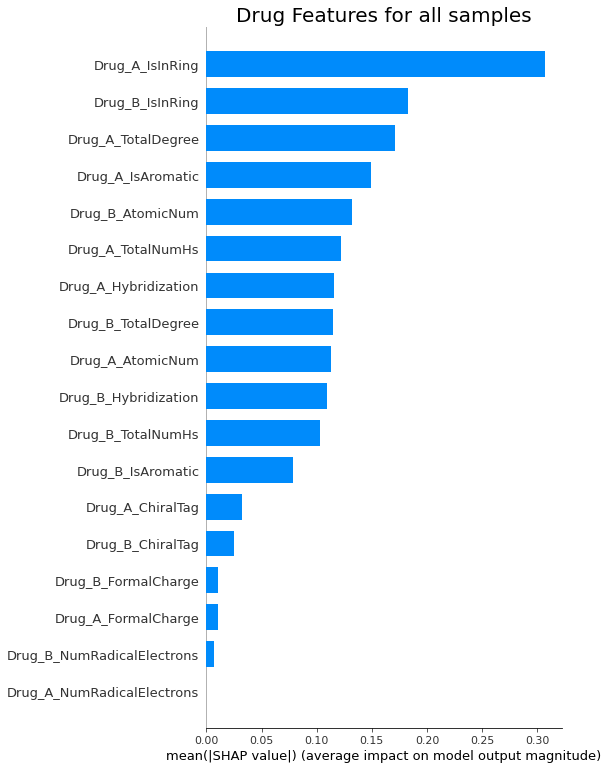

In [88]:
sp = shap.summary_plot(concat_folds_min_ones_delta_thresh[:, :nr_drug_feat],
                  test_features_TP_ones_delta_thresh[:, :nr_drug_feat],
                  feature_names=all_feat[:nr_drug_feat],
                  max_display=nr_drug_feat, show=False, plot_type="bar", plot_size=shap_plot_size)
plt.title("Drug Features for all samples")
plt.show()

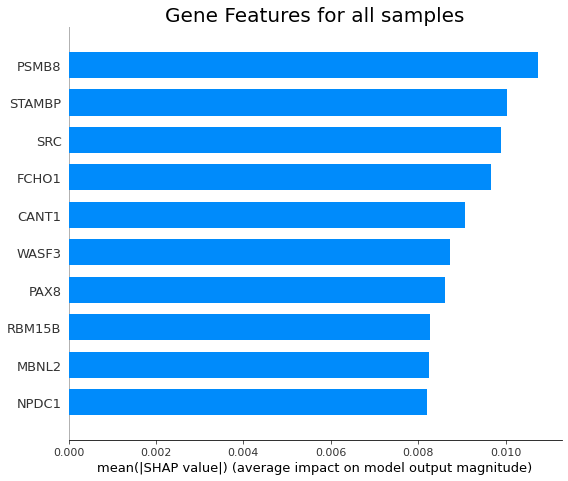

In [89]:
shap.summary_plot(concat_folds_min_ones_delta_thresh[:, nr_drug_feat:],
                  test_features_TP_ones_delta_thresh[:, nr_drug_feat:],
                  feature_names=all_feat[nr_drug_feat:],
                  max_display=10, show=False, plot_type="bar", plot_size=shap_plot_size)
plt.title("Gene Features for all samples")
plt.show()

In [115]:
vals= np.abs(concat_folds_min_ones_delta_thresh[:, :nr_drug_feat]).mean(0)

feature_importance = pd.DataFrame(list(zip(all_feat[:nr_drug_feat], vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)

# feature_importance.head(10)

# for gene in list(feature_importance.head(10)['col_name']):
#     print(gene)

feature_importance['feature_importance_vals'].sum() #genes: 5.4858246, #drugs: 1.7817795

1.7817795

In [ ]:
shap.get(concat_folds_min_ones_delta_thresh[:, nr_drug_feat:],
                  test_features_TP_ones_delta_thresh[:, nr_drug_feat:],

### Attributions for Cell Line

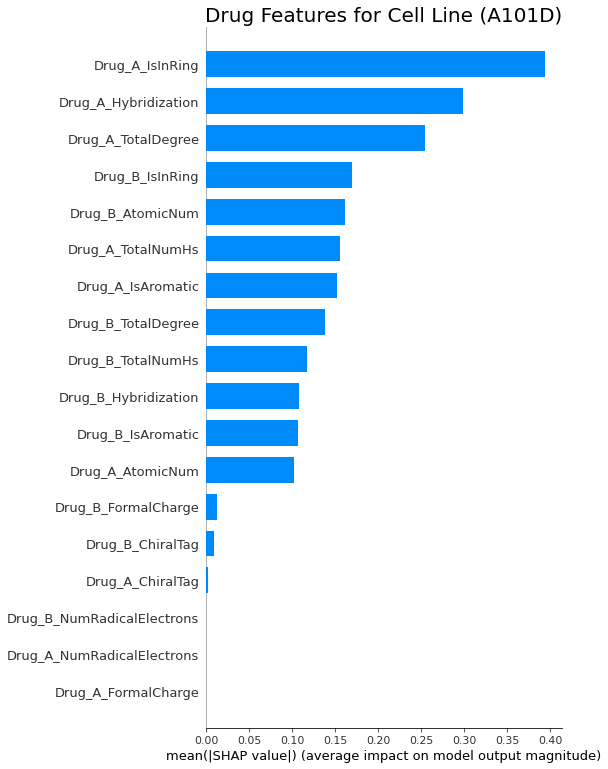

In [90]:
shap.summary_plot(concat_folds_min_CellLine_ones_delta_thresh[:, :nr_drug_feat],
                  test_features_TP_CellLine_ones_delta_thresh[:, :nr_drug_feat],
                  feature_names=all_feat[:nr_drug_feat],
                  max_display=nr_drug_feat, show=False, plot_type="bar", plot_size=shap_plot_size)
plt.title(f"Drug Features for Cell Line ({sel_CellLine})")
plt.show()

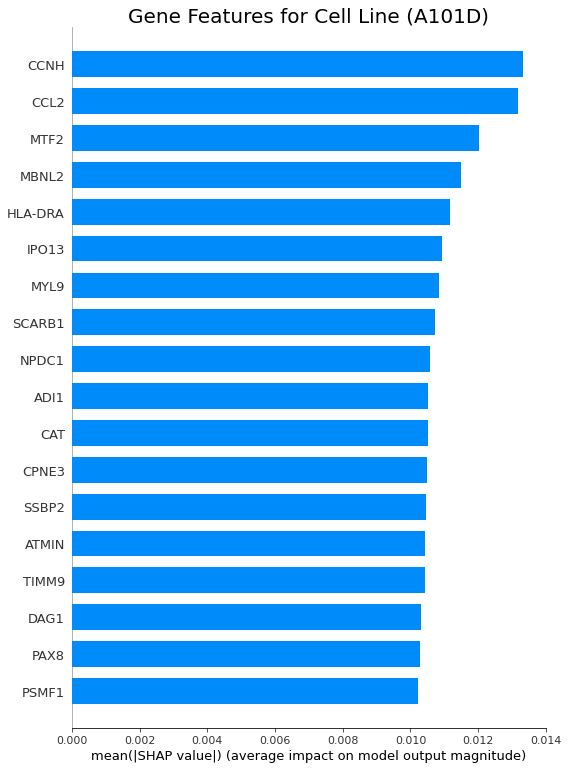

In [91]:
shap.summary_plot(concat_folds_min_CellLine_ones_delta_thresh[:, nr_drug_feat:],
                  test_features_TP_CellLine_ones_delta_thresh[:, nr_drug_feat:],
                  feature_names=all_feat[nr_drug_feat:],
                  max_display=nr_drug_feat, show=False, plot_type="bar", plot_size=shap_plot_size)
plt.title(f"Gene Features for Cell Line ({sel_CellLine})")
plt.show()

### Attributions for Instance

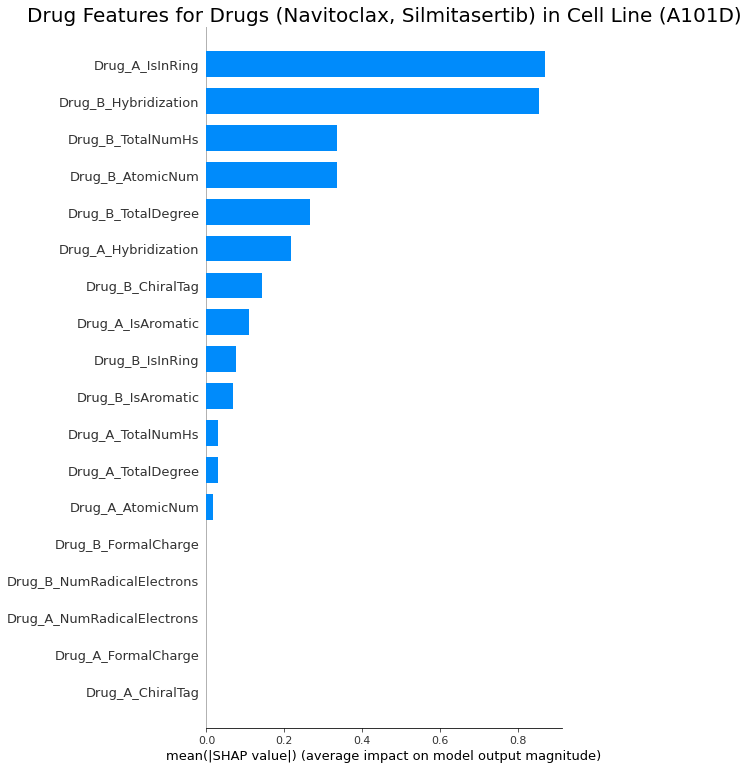

In [92]:
shap.summary_plot(concat_folds_min_Instance[:, :nr_drug_feat],
                  test_features_TP_Instance[:, :nr_drug_feat],
                  feature_names=all_feat[:nr_drug_feat],
                  max_display=nr_drug_feat, show=False, plot_type="bar", plot_size=shap_plot_size)
plt.title(f"Drug Features for Drugs ({sel_Drug1_ID}, {sel_Drug2_ID}) in Cell Line ({sel_CellLine})")
plt.show()

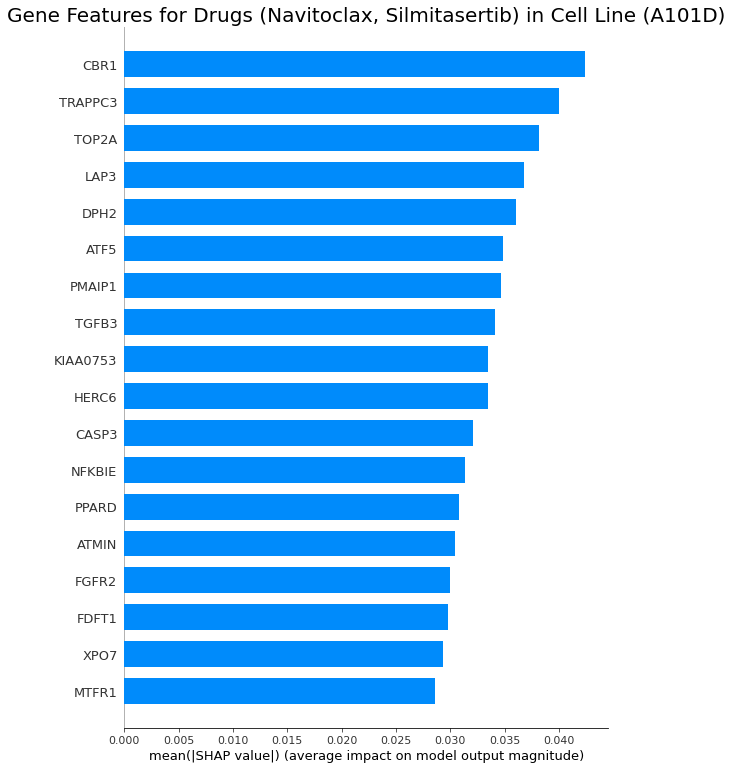

In [93]:
shap.summary_plot(concat_folds_min_Instance[:, nr_drug_feat:],
                  test_features_TP_Instance[:, nr_drug_feat:],
                  feature_names=all_feat[nr_drug_feat:],
                  max_display=nr_drug_feat, show=False, plot_type="bar", plot_size=shap_plot_size)
plt.title(f"Gene Features for Drugs ({sel_Drug1_ID}, {sel_Drug2_ID}) in Cell Line ({sel_CellLine})")
plt.show()

### Grouped SHAP

In [94]:
from itertools import repeat, chain
revert_dict = lambda d: dict(chain(*[zip(val, repeat(key)) for key, val in d.items()]))

In [95]:
# source: https://www.kaggle.com/code/estevaouyra/shap-advanced-uses-grouping-and-correlation/notebook

def grouped_shap(shap_vals, features, groups):
    groupmap = revert_dict(groups)
    shap_Tdf = pd.DataFrame(shap_vals, columns=pd.Index(features, name='features')).T
    shap_Tdf['group'] = shap_Tdf.reset_index().features.map(groupmap).values
    shap_grouped = shap_Tdf.groupby('group').sum().T
    return shap_grouped

In [96]:
drug_shap_grouped = grouped_shap(concat_folds_min_ones_delta_thresh[:, :nr_drug_feat],
                                 all_feat[:nr_drug_feat],
                                 grouped_feats)
# drug_shap_grouped

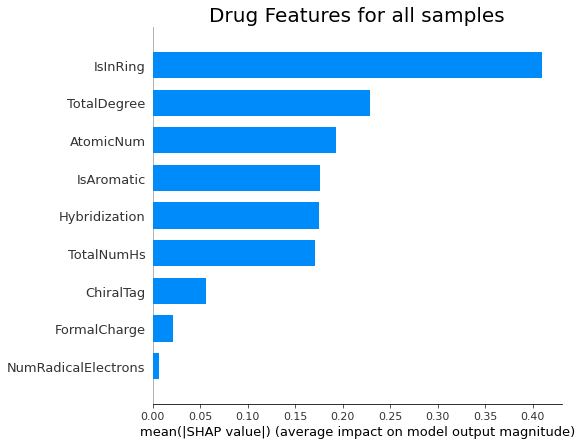

In [97]:
sp = shap.summary_plot(drug_shap_grouped.values, features=drug_shap_grouped.columns,
                       show=False, plot_type="bar", plot_size=shap_plot_size)
plt.title("Drug Features for all samples")
plt.show()